Script per eseguire l'analisi con informazioni aggiuntive del modello clip con gli iperparametri settati. In questo caso della configurazione migliore secondo la grid search.

In [2]:
# Funzione per provare la varianete con Data Augmntation Testuale

import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')
import random
from nltk.corpus import wordnet

def synonym_replacement(text, p=0.3):
    words = text.split()
    new_words = []
    for word in words:
        if random.random() < p:
            synonyms = wordnet.synsets(word)
            lemmas = [lemma.name().replace('_', ' ') for s in synonyms for lemma in s.lemmas()]
            if lemmas:
                new_word = random.choice(lemmas)
                new_words.append(new_word)
            else:
                new_words.append(word)
        else:
            new_words.append(word)
    return ' '.join(new_words)


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\conca\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\conca\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [4]:
import os
import json
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torchvision import transforms
from transformers import CLIPProcessor, CLIPModel
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


print(torch.cuda.is_available())


# CONFIG 
TRAIN_DATA_DIR = "../pre_processing/dataset/train/"
TRAIN_ANNOTATIONS_PATH = '../pre_processing/dataset/train.json'

VAL_DATA_DIR = "../pre_processing/dataset/val/"
VAL_ANNOTATIONS_PATH = '../pre_processing/dataset/val.json'

BATCH_SIZE = 8
EPOCHS = 10
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# MLP classifier 
class MultimodalClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim=512):
        super().__init__()
        self.classifier = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.0),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()
        )
        #self.train = train

    def forward(self, x):
        return self.classifier(x)

# Dataset 
class MultimodalDataset(Dataset):
    def __init__(self, annotations, img_folder, processor, label_encoder, transform=None, train=True):
        self.annotations = annotations
        self.img_folder = img_folder
        self.processor = processor
        self.label_encoder = label_encoder
        self.transform = transform or transforms.Compose([
            transforms.Resize((224, 224)),
            # Decommenta per la varianete con Data Augmentation visiva
            # transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
            # transforms.RandomHorizontalFlip(),
            # transforms.RandomRotation(degrees=15),
            # transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
            transforms.ToTensor(),
        ])
        self.train = True

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        item = self.annotations[idx]
        text = item["text"]
        
        import re
        #text = [item["text"] for item in data if "text" in item]
        text = text.lower()
        text = re.sub(r"\\n", " ", text).strip() 
        text = re.sub(r"\n", " ", text).strip() 
        text = re.sub(r"\\", " ", text).strip() 
        text = re.sub(r"  ", " ", text).strip()
        
        # TEXT AUGMENTATION SOLO IN TRAINING
        # if self.transform and self.train:  # Aggiungi un flag `self.train` al dataset
        #     text = synonym_replacement(text, p=0.2)
        
        image_path = os.path.join(self.img_folder, item["label"], item["image"])
        image = Image.open(image_path).convert("RGB")
        image = self.transform(image)
        label = self.label_encoder.transform([item["label"]])[0]
        return text, image, torch.tensor(label, dtype=torch.float32)

# Load data 
with open(TRAIN_ANNOTATIONS_PATH, "r", encoding='utf-8') as f:
    train_annotations = json.load(f)

with open(VAL_ANNOTATIONS_PATH, "r", encoding='utf-8') as f:
    val_annotations = json.load(f)

    

all_labels = [a["label"] for a in train_annotations + val_annotations]
label_encoder = LabelEncoder()
label_encoder.fit(all_labels)

# Load del modello CLIP 
clip_model = CLIPModel.from_pretrained("openai/clip-vit-large-patch14").to(DEVICE)
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-large-patch14")

# Freeze CLIP
clip_model.eval()
for param in clip_model.parameters():
    param.requires_grad = False
    
#for name, module in clip_model.named_modules():
#  print(name)

unlock = False

# Scongela ultimi blocchi
# Scongela solo l'ultimo blocco dell'encoder visivo
last_vision_block = clip_model.vision_model.encoder.layers[-3:]
for param in last_vision_block.parameters():
    param.requires_grad = unlock
# Scongela solo l'ultimo blocco dell'encoder testuale
last_text_block = clip_model.text_model.encoder.layers[-3:]
for param in last_text_block.parameters():
    param.requires_grad = unlock
for param in clip_model.text_model.final_layer_norm.parameters():
    param.requires_grad = unlock
for param in clip_model.vision_model.post_layernorm.parameters():
    param.requires_grad = unlock
    
    
#DataLoader etc
train_dataset = MultimodalDataset(train_annotations, TRAIN_DATA_DIR, clip_processor, label_encoder)
val_dataset = MultimodalDataset(val_annotations, VAL_DATA_DIR, clip_processor, label_encoder)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

# Classifier 
embedding_dim = 768 + 768 # Testo + immagine
classifier = MultimodalClassifier(embedding_dim).to(DEVICE)

# Optimizer e loss 
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(classifier.parameters(), lr=1e-2, weight_decay=0)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS, eta_min=1e-7)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, gamma=0.1, step_size=10)
# scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, 0.9)
# scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)


train_losses = list()
val_losses = list()
# Training loop 
for epoch in range(EPOCHS):
    classifier.train()
    total_loss = 0
    for texts, images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
        inputs = clip_processor(text=texts, 
                                images=images, 
                                return_tensors="pt", 
                                padding=True, 
                                truncation=True,
                                do_rescale=False).to(DEVICE)
        with torch.no_grad():
            clip_outputs = clip_model(**inputs)
            text_embeds = clip_outputs.text_embeds
            image_embeds = clip_outputs.image_embeds

        features = torch.cat([text_embeds, image_embeds], dim=1)
        logits = classifier(features).squeeze()

        loss = criterion(logits, labels.to(DEVICE))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Train loss: {total_loss / len(train_loader):.4f}")
    train_losses.append(total_loss / len(train_loader))

    # Validation
    classifier.eval()
    all_preds = []
    all_labels = []

    val_loss = 0
    with torch.no_grad():
        for texts, images, labels in val_loader:
            inputs = clip_processor(text=texts, 
                                    images=images,
                                    return_tensors="pt", 
                                    padding=True, 
                                    truncation=True,
                                    do_rescale=False).to(DEVICE)
            clip_outputs = clip_model(**inputs)
            
            
            
            text_embeds = clip_outputs.text_embeds
            image_embeds = clip_outputs.image_embeds
            features = torch.cat([text_embeds, image_embeds], dim=1)
            logits = classifier(features).squeeze()
            
            loss = criterion(logits, labels.to(DEVICE))
            val_loss += loss.item()
            
            #scheduler.step()
            
            preds = (logits > 0.5).float()
            all_preds.extend(preds.tolist())
            all_labels.extend(labels.tolist())
            
    val_loss /= len(val_loader)  # Media sulla validation
    val_losses.append(val_loss)
    print(f"Val loss: {val_loss:.4f}")
            
    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds, average='macro', zero_division=0)
    rec = recall_score(all_labels, all_preds, average='macro', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)

    print(f"Validation accuracy: {acc:.4f}")
    print(f"Precision (macro): {prec:.4f}")
    print(f"Recall (macro): {rec:.4f}")
    print(f"F1-score (macro): {f1:.4f}")


True


Epoch 1: 100%|██████████| 150/150 [05:04<00:00,  2.03s/it]


Train loss: 0.4405
Val loss: 0.4043
Validation accuracy: 0.8000
Precision (macro): 0.7979
Recall (macro): 0.7350
F1-score (macro): 0.7520


Epoch 2: 100%|██████████| 150/150 [04:52<00:00,  1.95s/it]


Train loss: 0.2337
Val loss: 0.4409
Validation accuracy: 0.8200
Precision (macro): 0.8119
Recall (macro): 0.7700
F1-score (macro): 0.7843


Epoch 3: 100%|██████████| 150/150 [04:47<00:00,  1.92s/it]


Train loss: 0.0990
Val loss: 0.6425
Validation accuracy: 0.7933
Precision (macro): 0.7772
Recall (macro): 0.7400
F1-score (macro): 0.7524


Epoch 4: 100%|██████████| 150/150 [04:50<00:00,  1.94s/it]


Train loss: 0.0315
Val loss: 0.7856
Validation accuracy: 0.8133
Precision (macro): 0.7894
Recall (macro): 0.8000
F1-score (macro): 0.7940


Epoch 5: 100%|██████████| 150/150 [04:48<00:00,  1.93s/it]


Train loss: 0.0241
Val loss: 0.7907
Validation accuracy: 0.8000
Precision (macro): 0.7816
Recall (macro): 0.8100
F1-score (macro): 0.7878


Epoch 6: 100%|██████████| 150/150 [04:49<00:00,  1.93s/it]


Train loss: 0.0147
Val loss: 0.7873
Validation accuracy: 0.8000
Precision (macro): 0.7755
Recall (macro): 0.7900
F1-score (macro): 0.7812


Epoch 7: 100%|██████████| 150/150 [04:48<00:00,  1.93s/it]


Train loss: 0.0409
Val loss: 1.0759
Validation accuracy: 0.8067
Precision (macro): 0.7857
Recall (macro): 0.7700
F1-score (macro): 0.7766


Epoch 8: 100%|██████████| 150/150 [04:49<00:00,  1.93s/it]


Train loss: 0.0392
Val loss: 1.1761
Validation accuracy: 0.7800
Precision (macro): 0.7530
Recall (macro): 0.7450
F1-score (macro): 0.7486


Epoch 9: 100%|██████████| 150/150 [04:49<00:00,  1.93s/it]


Train loss: 0.0185
Val loss: 1.2315
Validation accuracy: 0.8267
Precision (macro): 0.8050
Recall (macro): 0.8050
F1-score (macro): 0.8050


Epoch 10: 100%|██████████| 150/150 [04:48<00:00,  1.92s/it]


Train loss: 0.0363
Val loss: 2.7478
Validation accuracy: 0.7867
Precision (macro): 0.7917
Recall (macro): 0.7100
F1-score (macro): 0.7273


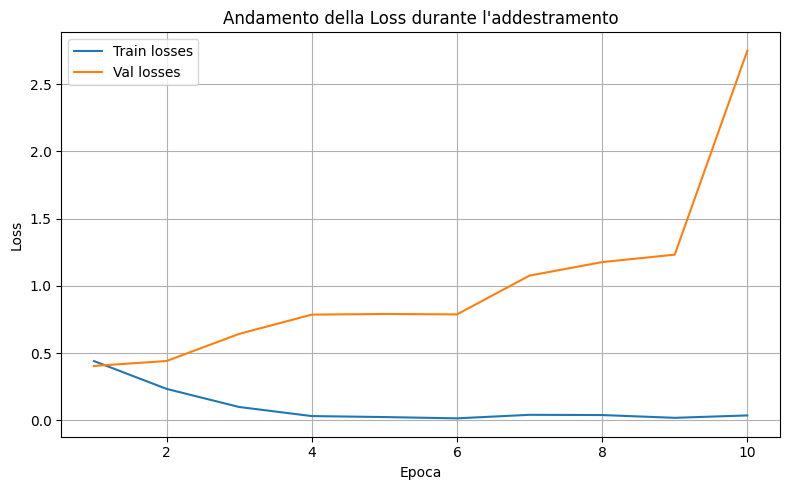

In [5]:
import matplotlib.pyplot as plt

# Numero di epoche
epochs = list(range(1, len(val_losses) + 1))

# Plot
plt.figure(figsize=(8, 5))
plt.plot(epochs, train_losses, label='Train losses')
plt.plot(epochs, val_losses, label='Val losses')
plt.xlabel('Epoca')
plt.ylabel('Loss')
plt.title('Andamento della Loss durante l\'addestramento')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Testing: 100%|██████████| 38/38 [01:13<00:00,  1.94s/it]


TEST RESULTS
Accuracy: 0.7967
Precision (macro): 0.8307
Recall (macro): 0.7100
F1-score (macro): 0.7301


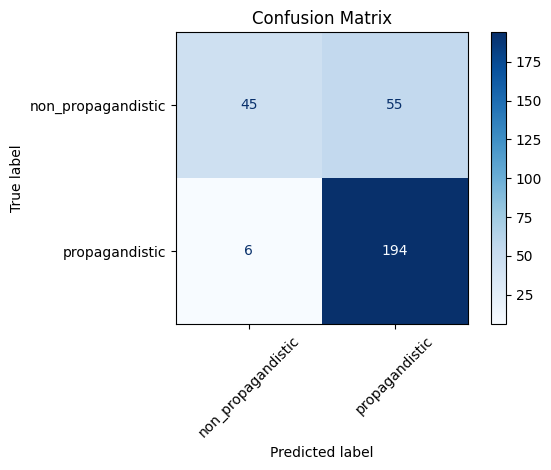


ESEMPI DI ERRORI DI CLASSIFICAZIONE:
Testo: *** senate republicans @nrsc .@edmarkey, this you? #weneednine expand the court
Etichetta corretta: non_propagandistic | Predetta: propagandistic
Immagine: ../pre_processing/dataset/test/non_propagandistic\prop_meme_18128.png


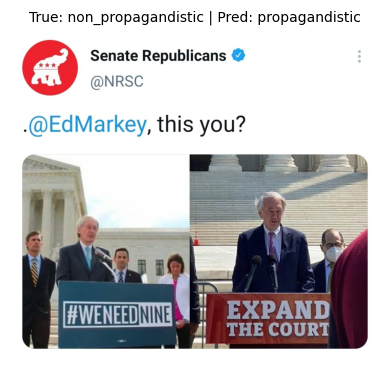

------------------------------------------------------------
Testo: fjames webb telescope my goodness, the universe is massive beyond our wildest imagination. wisconsin state tribintage but it still revolves around me!
Etichetta corretta: non_propagandistic | Predetta: propagandistic
Immagine: ../pre_processing/dataset/test/non_propagandistic\prop_meme_17955.png


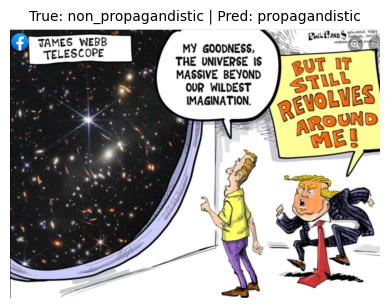

------------------------------------------------------------
Testo: name 1 thing you trust more than the joe biden ore
Etichetta corretta: non_propagandistic | Predetta: propagandistic
Immagine: ../pre_processing/dataset/test/non_propagandistic\prop_meme_18038.png


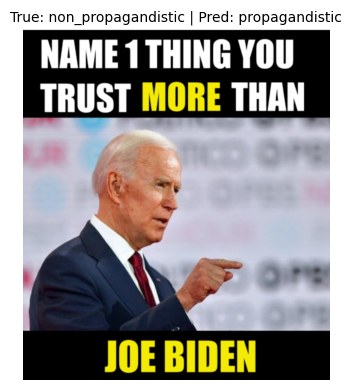

------------------------------------------------------------
Testo: during the debate on the health & social care bill, nadhim zahawi helped the bill pass with a crucial speech where he called the bill a 'brilliant piece of legislation. after it passed, a company called sthree received contracts worth £2.6m to profit out of the nhs. what's the connection? zahawi is a director at sthree! pileus
Etichetta corretta: propagandistic | Predetta: non_propagandistic
Immagine: ../pre_processing/dataset/test/propagandistic\prop_meme_8701.png


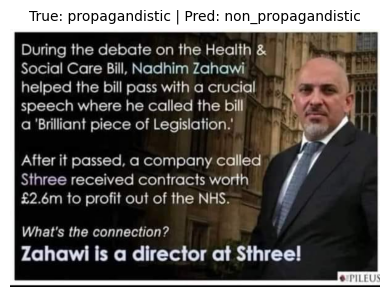

------------------------------------------------------------
Testo: liberal a person so open-minded their brains have fallen out
Etichetta corretta: non_propagandistic | Predetta: propagandistic
Immagine: ../pre_processing/dataset/test/non_propagandistic\prop_meme_17821.png


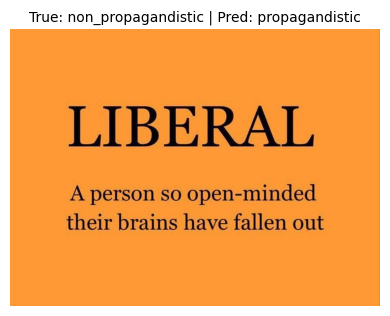

------------------------------------------------------------


In [6]:
import json
import os
from tqdm import tqdm
from PIL import Image
import torch
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def run_test(test_annotations_path, data_dir, classifier, clip_model, clip_processor, label_encoder):
    # Carica le annotazioni e costruisci la lista dei path immagine
    with open(test_annotations_path, "r", encoding='utf-8') as f:
        test_annotations = json.load(f)
    image_paths = [
        os.path.join(data_dir, ann["label"], ann["image"])
        for ann in test_annotations
    ]

    test_dataset = MultimodalDataset(test_annotations, data_dir, clip_processor, label_encoder, train=False)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

    classifier.eval()
    all_preds = []
    all_labels = []
    all_texts = []
    all_true_labels_str = []
    all_pred_labels_str = []
    all_used_image_paths = []

    i = 0  # contatore globale per accedere ai path immagine
    with torch.no_grad():
        for texts, images, labels in tqdm(test_loader, desc="Testing"):
            inputs = clip_processor(text=texts,
                                    images=images,
                                    return_tensors="pt",
                                    padding=True,
                                    truncation=True,
                                    do_rescale=False).to(DEVICE)
            clip_outputs = clip_model(**inputs)
            text_embeds = clip_outputs.text_embeds
            image_embeds = clip_outputs.image_embeds
            features = torch.cat([text_embeds, image_embeds], dim=1)
            
            logits = classifier(features).squeeze()
            preds = (logits > 0.5).float().cpu()
            labels = labels.cpu()

            batch_size = len(texts)
            all_preds.extend(preds.tolist())
            all_labels.extend(labels.tolist())
            all_texts.extend(texts)

            all_true_labels_str.extend(label_encoder.inverse_transform(labels.int()))
            all_pred_labels_str.extend(label_encoder.inverse_transform(preds.int()))
            all_used_image_paths.extend(image_paths[i:i + batch_size])
            i += batch_size

    # METRICHE
    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds, average='macro', zero_division=0)
    rec = recall_score(all_labels, all_preds, average='macro', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)

    print(f"\nTEST RESULTS")
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision (macro): {prec:.4f}")
    print(f"Recall (macro): {rec:.4f}")
    print(f"F1-score (macro): {f1:.4f}")

    # CONFUSION MATRIX
    cm = confusion_matrix(all_true_labels_str, all_pred_labels_str, labels=label_encoder.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
    disp.plot(xticks_rotation=45, cmap="Blues")
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()

    # ESEMPI DI ERRORI
    print("\nESEMPI DI ERRORI DI CLASSIFICAZIONE:")
    count = 0
    for text, true_label, pred_label, img_path in zip(all_texts, all_true_labels_str, all_pred_labels_str, all_used_image_paths):
        if true_label != pred_label:
            print(f"Testo: {text}")
            print(f"Etichetta corretta: {true_label} | Predetta: {pred_label}")
            print(f"Immagine: {img_path}")
            try:
                image = Image.open(img_path).convert("RGB")
                plt.figure(figsize=(4, 4))
                plt.imshow(image)
                plt.axis("off")
                plt.title(f"True: {true_label} | Pred: {pred_label}", fontsize=10)
                plt.tight_layout()
                plt.show()
            except FileNotFoundError:
                print(f"Immagine non trovata: {img_path}")
            print("-" * 60)
            count += 1
        if count >= 5:
            break  # mostra solo i primi 5 errori


# CONFIG 
TEST_DATA_DIR = "../pre_processing/dataset/test/"
TEST_ANNOTATIONS_PATH = "../pre_processing/dataset/test.json"

run_test(TEST_ANNOTATIONS_PATH, TEST_DATA_DIR, classifier, clip_model, clip_processor, label_encoder)

torch.save(classifier, f"../pre_processing/model/classifier.pt")


In [7]:
#torch.save(classifier, f"saves/classifier.pt")